In [1]:
# Importing packages
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python

import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import random
import datetime
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from matplotlib import gridspec

import itertools
from itertools import combinations

from PIL import Image
from io import BytesIO

# Setting directory
# os.chdir("/Users/wnguyen/Dropbox/CR/mcfigs_test") # set the working directory

Reading in data!

In [3]:
# Importing data
data_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/CostaRica_Chemistry_20200518.csv'
data_2_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/lia_Q.csv' # DS Q
data_3_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/UpQDataSlam.csv'# US Q
data_4_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/down_q_measured.csv'# DS Q Measured
data_5_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/up_q_measured.csv'# US Q Measured
data_6_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/DownstreamMiller.csv' # Rain
data_7_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Ratios/Ratios.csv' # US/DS ratios
data_8_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/Well_SWH_GSA.csv' # Well data
data_9_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/GSA/US_SC_YSI_PK1.csv' # US SC
data_10_url = 'https://raw.githubusercontent.com/wdnguyen/CR/master/GSA/DS_SC_YSI_PK2.csv' # DS SC

# Read data from url as pandas dataframe
df = pd.read_csv(data_url)
df2 = pd.read_csv(data_2_url)
df3 = pd.read_csv(data_3_url)
df4 = pd.read_csv(data_4_url)
df5 = pd.read_csv(data_5_url)
df6 = pd.read_csv(data_6_url)
df7 = pd.read_csv(data_7_url)
df8 = pd.read_csv(data_8_url)
df9 = pd.read_csv(data_9_url)
df10 = pd.read_csv(data_10_url)

# Making date columns datetime friendly (in case I wanted to index later)
df['SamplingDate'] = pd.to_datetime(df['SamplingDate'])
df['Chemetrics_Acidified_Date'] = pd.to_datetime(df['Chemetrics_Acidified_Date'])
df2['Date'] = pd.to_datetime(df2['Date'])
df3['Date'] = pd.to_datetime(df3['Date'])
df4['Date'] = pd.to_datetime(df4['Date'])
df5['Date'] = pd.to_datetime(df5['Date'])
df6['Date'] = pd.to_datetime(df6['Date'])
df8['Date'] = pd.to_datetime(df8['Date'])
df9['Date'] = pd.to_datetime(df9['Date'])
df10['Date'] = pd.to_datetime(df10['Date'])

# Filtering endmembers
df_rain = df[df['Site'] == "Rain"].reset_index(drop=True) # Endmember 1 = Rain
df_soil = df[df['Site'] == "Soil"].reset_index(drop=True) # Endmember 2 = Soil
df_spring = df[df['Site'] == "Spring"].reset_index(drop=True) # Endmember 3a = Spring
df_us = df[(df['Site'] == "Upstream") & (df['SamplingDate'] < '2019')].reset_index(drop=True) # Endmember 3b = Upstream, not including 2019

# Filtering mixing batches
df_ds = df[(df['Site'] == "Downstream") & (df['SamplingDate'] < '2019')] # Mixing batch a, not including 2019
df_ds = df_ds[~df_ds['ID'].str.contains("Howler")] # Only want the DS samples
df_ds = df_ds[~df_ds['ID'].str.contains("DS9Bot")].reset_index(drop=True) # Filtering out DS9Bot (duplicate)
df_stream = df[(df['Source'] == "Stream") & (df['SamplingDate'] < '2019')].reset_index() # Mixing batch b, not including 2019

# Summary statistics:
df_summary = df.groupby("Site").describe()

# For this analysis, I'm dropping the US samples that are missing 
# from the DS samples (because the ISCO was not installed correctly):
# Samples 4 - 8
df_us = df_us.drop(df_us.index[3:8]).reset_index(drop=True)
# df_us = df_us.drop(df_us.index[4]).reset_index(drop=True) # Dropping sample 10
# df_ds = df_ds.drop(df_ds.index[4]).reset_index(drop=True) # Dropping sample 10

In [4]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [51]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"

Setting up a running mean function

In [6]:
# Running mean function
def running_mean(in_array,window):
    import numpy as np
    w = int(np.floor(window/2))
    mean_array = np.zeros(len(in_array),dtype=np.float64)
    i = int(w)
    while i < len(in_array)-w:
        mean_array[i] = np.mean(in_array[(i-w):(i+w+1)])
        i += 1
    window_used = int(w*2 +1)
    return(mean_array,window_used)

In [7]:
# Adding running mean to US and DS hydrograph
ds_q = df2['Q'].to_numpy() # taking discharge values
rm_ds_q = running_mean(ds_q, 5) # returns 2-D array with running mean, making first two values and last two values 0, AND returning the window used.

us_q = df3['Q'].to_numpy()
rm_us_q = running_mean(us_q, 5)

df2['MovingAverage5'] = rm_ds_q[0]  # only care about first array with moving average
df3['MovingAverage5'] = rm_us_q[0] 

df2['MovingAverage5'] = df2['MovingAverage5'].replace([0], np.nan) # replace first and last two values with NaNs
df3['MovingAverage5'] = df3['MovingAverage5'].replace([0], np.nan)

[Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '5'),
 Text(0, 0, '4'),
 Text(0, 0, '3'),
 Text(0, 0, '2'),
 Text(0, 0, '1'),
 Text(0, 0, '0')]

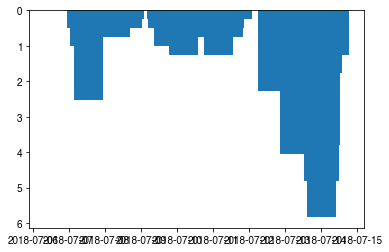

In [8]:
# Rain df6
df6_copy = df6.copy()
df6_copy['Rain'] = -1 * df6_copy['Rain']

fig, ax = plt.subplots()
ax.bar(df6_copy['Date'], df6_copy['Rain'])
ticks =  ax.get_yticks()
ax.set_yticklabels([int(abs(tick)) for tick in ticks])

# plt.show()

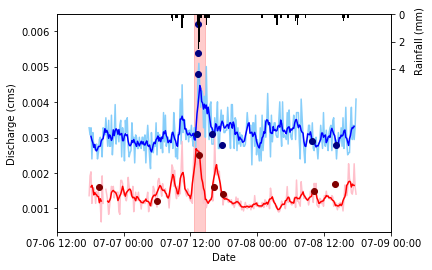

In [16]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d %H:%M')

# ax1.xaxis.set_major_locator(hours)
# ax1.xaxis.set_major_formatter(h_fmt)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'],df3['Q'],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = "blue", label = "DS")
ax1.plot(df3['Date'], df3['MovingAverage5'], '-', color = "red", label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")

ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-16,-0)
ax2.set_yticks([-4,-2,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cms)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)


t = ax2.text(1.1, 0.88, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()
# plt.ylim(8,12)
# plt.xlim(0,2000)

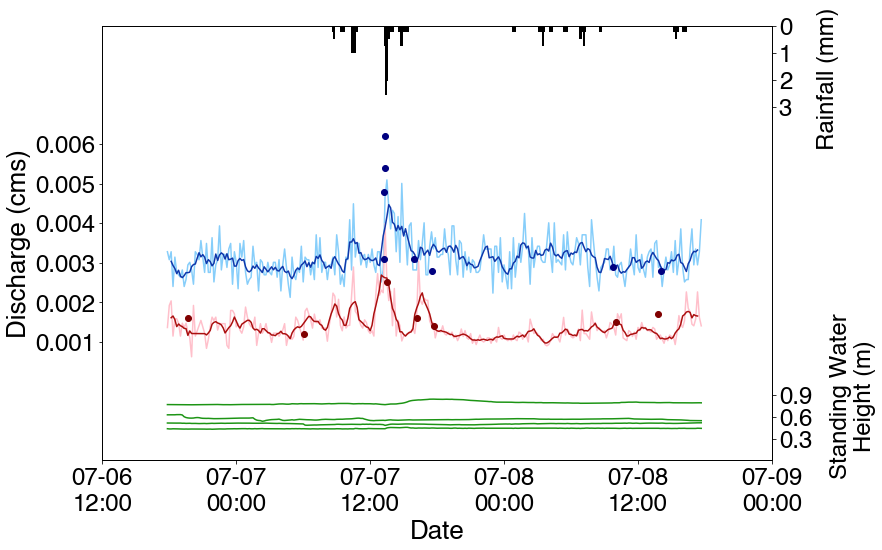

In [53]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

bluec = [0.06,0.22,0.67]
redc = [0.67,0.06,0.06]
yellowc = [1,0.71,0.1]
greenc = [0.11,0.58,0.08]

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d\n%H:%M')

#########
SMALL_SIZE = 24
MEDIUM_SIZE = 26
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = [12,8]

######### US samples have some NaNs making line discontinuous, adding mask
us_raw_mask = np.isfinite(df3['Q'])
us_ma_mask = np.isfinite(df3['MovingAverage5'])
#########

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'][us_raw_mask],df3['Q'][us_raw_mask],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = bluec, label = "DS")
ax1.plot(df3['Date'][us_ma_mask], df3['MovingAverage5'][us_ma_mask], '-', color = redc, label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")


ax1.set_ylim(-0.002,0.009)
ax1.set_yticks([0.001,0.002,0.003,0.004,0.005,0.006])


ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-16,-0)
ax2.set_yticks([-3,-2,-1,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

# ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)


ax3.plot(df8['Date'],df8['Well0'],'-', color = greenc, label = 'Well0')
ax3.plot(df8['Date'],df8['Well2'],'-', color = greenc, label = 'Well2')
ax3.plot(df8['Date'],df8['Well3'],'-', color = greenc, label = 'Well3')
ax3.plot(df8['Date'],df8['Well5'],'-', color = greenc, label = 'Well5')

ax3.set_ylim(0.0,6.0)
ax3.set_yticks([0.3,0.6,0.9])

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (cms)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)
ax3.xaxis.set_major_locator(hours)
ax3.xaxis.set_major_formatter(h_fmt)
ax3.set_xlim(xmin, xmax)

t = ax2.text(1.1, 0.88, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

t = ax3.text(1.12, 0.15, 'Standing Water', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax3.transAxes)

t = ax3.text(1.155, 0.15, 'Height (m)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax3.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()

# fig.savefig('fig1.png', dpi = 300)

'''
# save figure
# (1) save the image in memory in PNG format
png1 = BytesIO()
fig.savefig(png1, format='png', dpi = 600, bbox_inches="tight")

# (2) load this image into PIL
png2 = Image.open(png1)

# (3) save as TIFF
png2.save('series.tiff')
png1.close()
'''

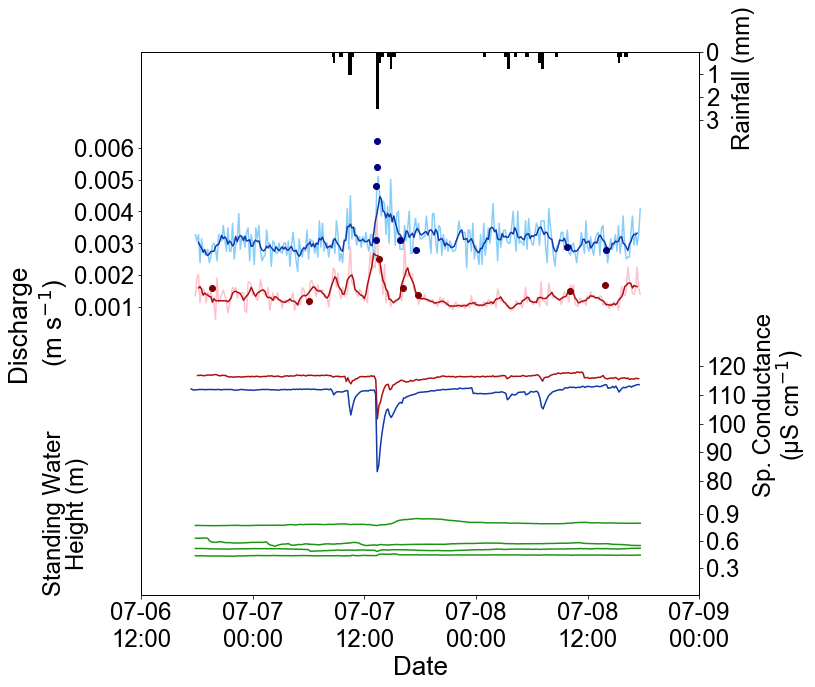

'\n# save figure\n# (1) save the image in memory in PNG format\npng1 = BytesIO()\nfig.savefig(png1, format=\'png\', dpi = 600, bbox_inches="tight")\n\n# (2) load this image into PIL\npng2 = Image.open(png1)\n\n# (3) save as TIFF\npng2.save(\'series.tiff\')\npng1.close()\n'

In [61]:
# Axis parameters
# xmin = pd.to_datetime('2018-07-06 00:00:00')
# xmax = pd.to_datetime('2018-07-09 00:00:00')

bluec = [0.06,0.22,0.67]
redc = [0.67,0.06,0.06]
yellowc = [1,0.71,0.1]
greenc = [0.11,0.58,0.08]

xmin = '2018-07-06 12:00'
xmax = '2018-07-09 00:00'

xmin = datetime.datetime.strptime(xmin, '%Y-%m-%d %H:%M')
xmax = datetime.datetime.strptime(xmax, '%Y-%m-%d %H:%M')

hours = mdates.HourLocator(interval = 12)
h_fmt = mdates.DateFormatter('%m-%d\n%H:%M')

#########
SMALL_SIZE = 24
MEDIUM_SIZE = 26
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = [10,10]

######### US samples have some NaNs making line discontinuous, adding mask
us_raw_mask = np.isfinite(df3['Q'])
us_ma_mask = np.isfinite(df3['MovingAverage5'])

us_sc_mask = np.isfinite(df9['SC'])
#########

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()

# fig = plt.figure(figsize=[9,12], dpi=600)
# plt.subplot(325)
# plt.scatter(cell_sizes,averages, c = "black", marker='o', alpha = 0.2, edgecolors = "none")
ax1.plot(df2['Date'],df2['Q'],'-', color = "lightskyblue")
ax1.plot(df3['Date'][us_raw_mask],df3['Q'][us_raw_mask],'-', color = "pink")
ax1.plot(df2['Date'], df2['MovingAverage5'], '-', color = bluec, label = "DS")
ax1.plot(df3['Date'][us_ma_mask], df3['MovingAverage5'][us_ma_mask], '-', color = redc, label = "US")
ax1.plot(df4['Date'], df4['Q'], 'o', color = "navy")
ax1.plot(df5['Date'], df5['Q'], 'o', color = "maroon")


ax1.set_ylim(-0.008,0.009)
ax1.set_yticks([0.001,0.002,0.003,0.004,0.005,0.006])


ax2.bar(df6_copy['Date'], df6_copy['Rain'], width=0.01, color='black')
ax2.set_ylim(-24,-0)
ax2.set_yticks([-3,-2,-1,-0])
ticks = ax2.get_yticks()
ax2.set_yticklabels([int(abs(tick)) for tick in ticks])

# ax1.axvspan(df_ds['SamplingDate'][5] - datetime.timedelta(hours=1), df_ds['SamplingDate'][5] + datetime.timedelta(hours=1), color = 'red', alpha=0.2)

ax3.plot(df9['Date'][us_sc_mask], df9['SC'][us_sc_mask],'-', color = redc, label = 'US')
ax3.plot(df10['Date'],df10['SC'],'-', color = bluec, label = 'DS')
ax3.set_ylim(40,230)
ax3.set_yticks([80,90,100,110,120])

ax4.plot(df8['Date'],df8['Well0'],'-', color = greenc, label = 'Well0')
ax4.plot(df8['Date'],df8['Well2'],'-', color = greenc, label = 'Well2')
ax4.plot(df8['Date'],df8['Well3'],'-', color = greenc, label = 'Well3')
ax4.plot(df8['Date'],df8['Well5'],'-', color = greenc, label = 'Well5')
ax4.set_ylim(0.0,6.0)
ax4.set_yticks([0.3,0.6,0.9])

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge\n(m s$^{-1}$)')
# ax2.set_ylabel('Rainfall (mm)')

ax1.xaxis.set_major_locator(hours)
ax1.xaxis.set_major_formatter(h_fmt)
ax1.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(hours)
ax2.xaxis.set_major_formatter(h_fmt)
ax2.set_xlim(xmin, xmax)
ax3.xaxis.set_major_locator(hours)
ax3.xaxis.set_major_formatter(h_fmt)
ax3.set_xlim(xmin, xmax)
ax4.xaxis.set_major_locator(hours)
ax4.xaxis.set_major_formatter(h_fmt)
ax4.set_xlim(xmin, xmax)

t = ax2.text(1.1, 0.95, 'Rainfall (mm)', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax2.transAxes)

t = ax3.text(1.138, 0.35, 'Sp. Conductance', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax3.transAxes)

t = ax3.text(1.195, 0.35, '(μS cm$^{-1})$', rotation=90, 
            verticalalignment='center', horizontalalignment='right', 
            transform=ax3.transAxes)

t = ax4.text(-0.175, 0.15, 'Standing Water', rotation=90, 
            verticalalignment='center', horizontalalignment='left', 
            transform=ax4.transAxes)

t = ax4.text(-0.135, 0.15, 'Height (m)', rotation=90, 
            verticalalignment='center', horizontalalignment='left', 
            transform=ax4.transAxes)

# plt.title('Hydrograph')
# ax1.legend(loc=0, edgecolor='black')

plt.show()

'''
fig.savefig('fig2.pdf', dpi = 600, bbox_inches='tight')

# save figure
# (1) save the image in memory in PNG format
png1 = BytesIO()
fig.savefig(png1, format='png', dpi = 600, bbox_inches="tight")

# (2) load this image into PIL
png2 = Image.open(png1)

# (3) save as TIFF
png2.save('series.tiff')
png1.close()
'''

In [57]:
df9

,Date,SC
0,2018-07-06 18:04:00,116.8
1,2018-07-06 18:14:00,116.8
2,2018-07-06 18:24:00,116.9
3,2018-07-06 18:34:00,116.8
4,2018-07-06 18:44:00,116.7
...,...,...
280,2018-07-08 16:50:00,115.6
281,2018-07-08 17:00:00,115.5
282,2018-07-08 17:10:00,115.8
283,2018-07-08 17:20:00,115.7
